# Camera calibration

Chessboard corner detection failed: ../CarND-Advanced-Lane-Lines/camera_cal/calibration4.jpg
Chessboard corner detection failed: ../CarND-Advanced-Lane-Lines/camera_cal/calibration5.jpg


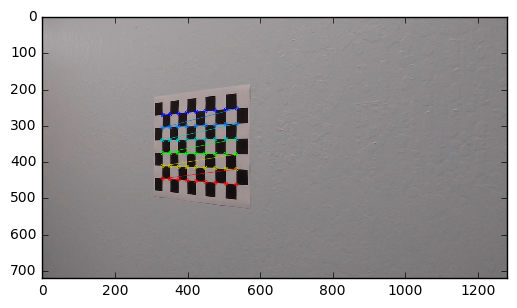

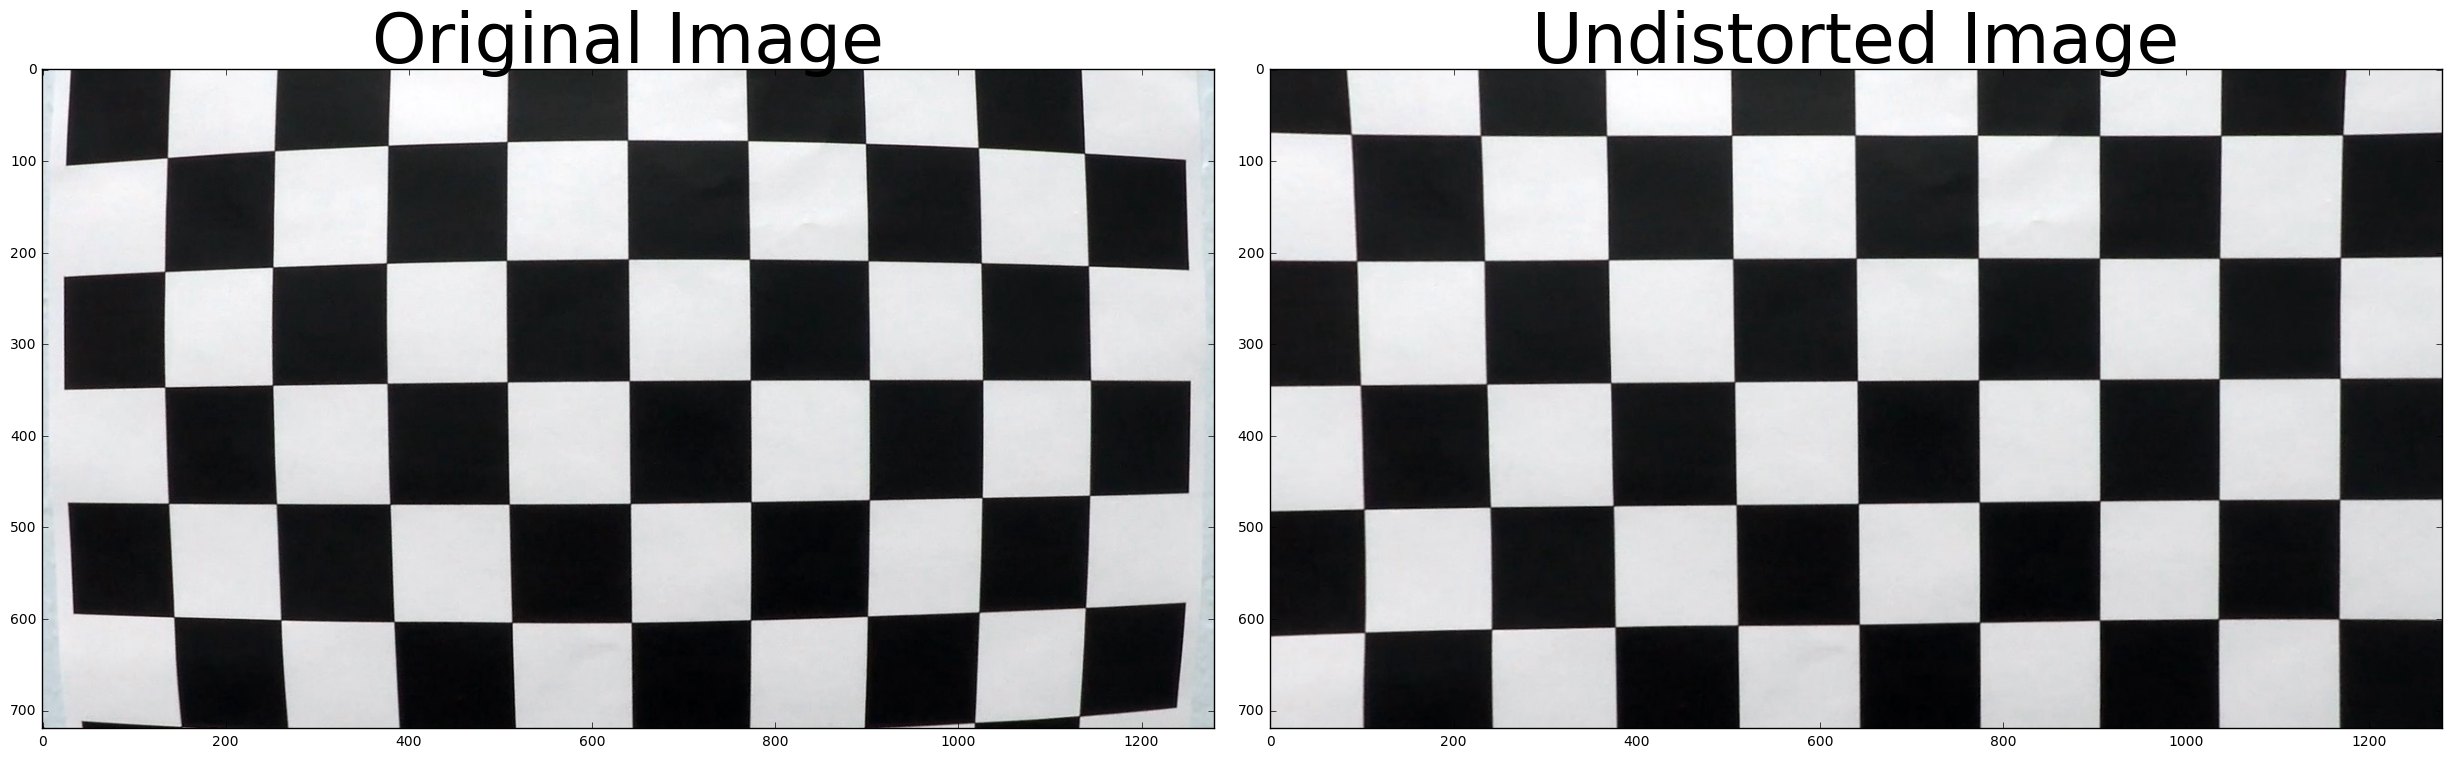

In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

calibration_images_filenames = glob.glob('../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
test_image_filename = '../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg'
show_corners_image_filename = '../CarND-Advanced-Lane-Lines/camera_cal/calibration7.jpg'
calibration_images_filenames.remove(test_image_filename)

inside_corners_count_x = 9
inside_corners_count_y = 6

objp = np.zeros((inside_corners_count_x * inside_corners_count_y, 3), np.float32)
objp[:,:2] = np.mgrid[0:inside_corners_count_x, 0:inside_corners_count_y].T.reshape(-1,2)

corners_res = []
objp_res = []

detection_failed_count = 0

for calibration_image_filename in calibration_images_filenames:
    img = cv2.imread(calibration_image_filename)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray_img, (inside_corners_count_x, inside_corners_count_y), None)
    
    if ret:
        corners_res.append(corners)
        objp_res.append(objp)
    else:
        print('Chessboard corner detection failed:', calibration_image_filename)
            
    if show_corners_image_filename == calibration_image_filename:
        img_corners = cv2.drawChessboardCorners(img, (inside_corners_count_x, inside_corners_count_y), corners, ret)
        plt.imshow(img_corners)

test_img = cv2.imread(test_image_filename)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp_res, corners_res, test_img.shape[0:2], None, None)

def undistort(image):
    undistorted_img = cv2.undistort(image, mtx, dist, None, mtx)
    
    return undistorted_img

undistorted_img = undistort(test_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Binay Image

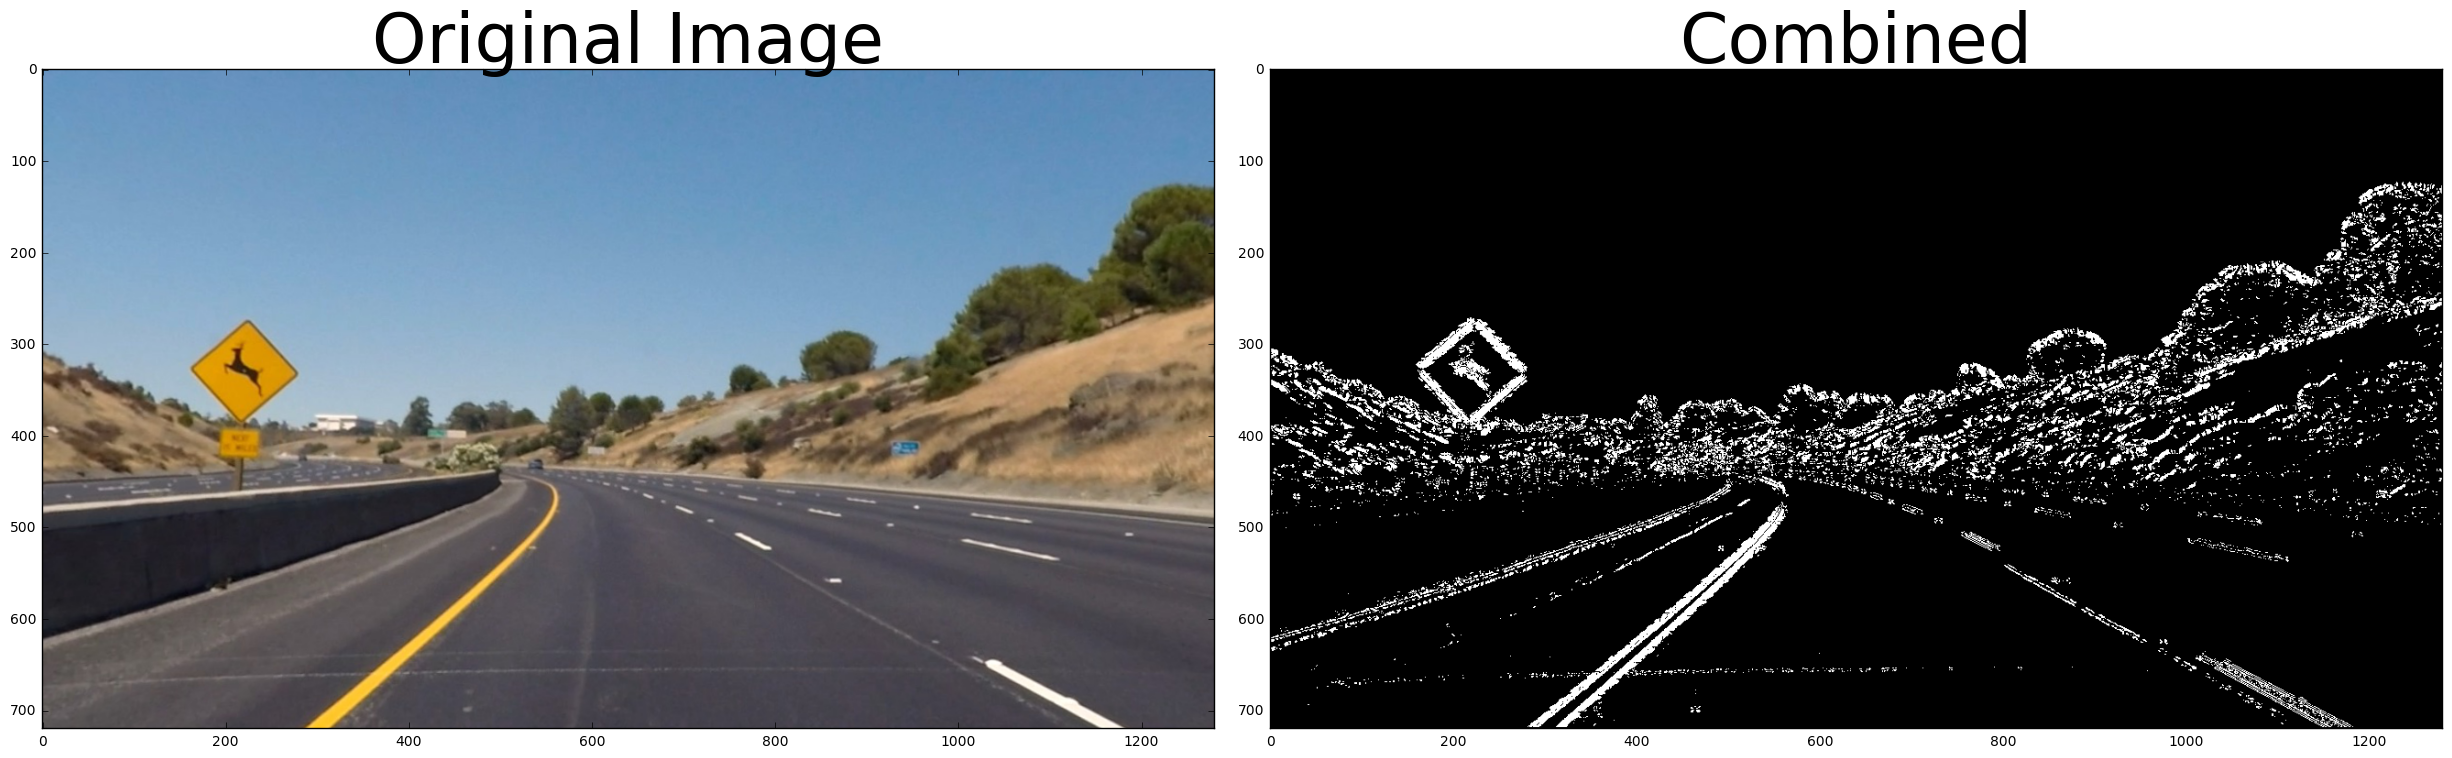

In [140]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    magnitude = np.sqrt(pow(sobel_x, 2) + pow(sobel_y, 2))
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    # 6) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 7) Return this mask as your binary_output image
    return sxbinary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobel_x)
    abs_sobely = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(direction)
    sxbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def get_binary_image(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx_l = abs_sobel_thresh(L, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    gradx_s = abs_sobel_thresh(S, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady_l = abs_sobel_thresh(L, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    grady_s = abs_sobel_thresh(S, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary_l = mag_thresh(L, sobel_kernel=ksize, mag_thresh=(20, 100))
    mag_binary_s = mag_thresh(S, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary_l = dir_threshold(L, sobel_kernel=ksize, thresh=(0.7, 1.3))
    dir_binary_s = dir_threshold(S, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(gradx_s)
    combined[((gradx_l == 1) & (grady_l == 1)) | ((mag_binary_l == 1) & (dir_binary_l == 1))] = 1
    combined[((gradx_s == 1) & (grady_s == 1)) | ((mag_binary_s == 1) & (dir_binary_s == 1))] = 1
    
    return combined

# Read in an image
raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/test2.jpg')

undistorted_img = undistort(raw_test_image)

combined = get_binary_image(undistorted_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective transform

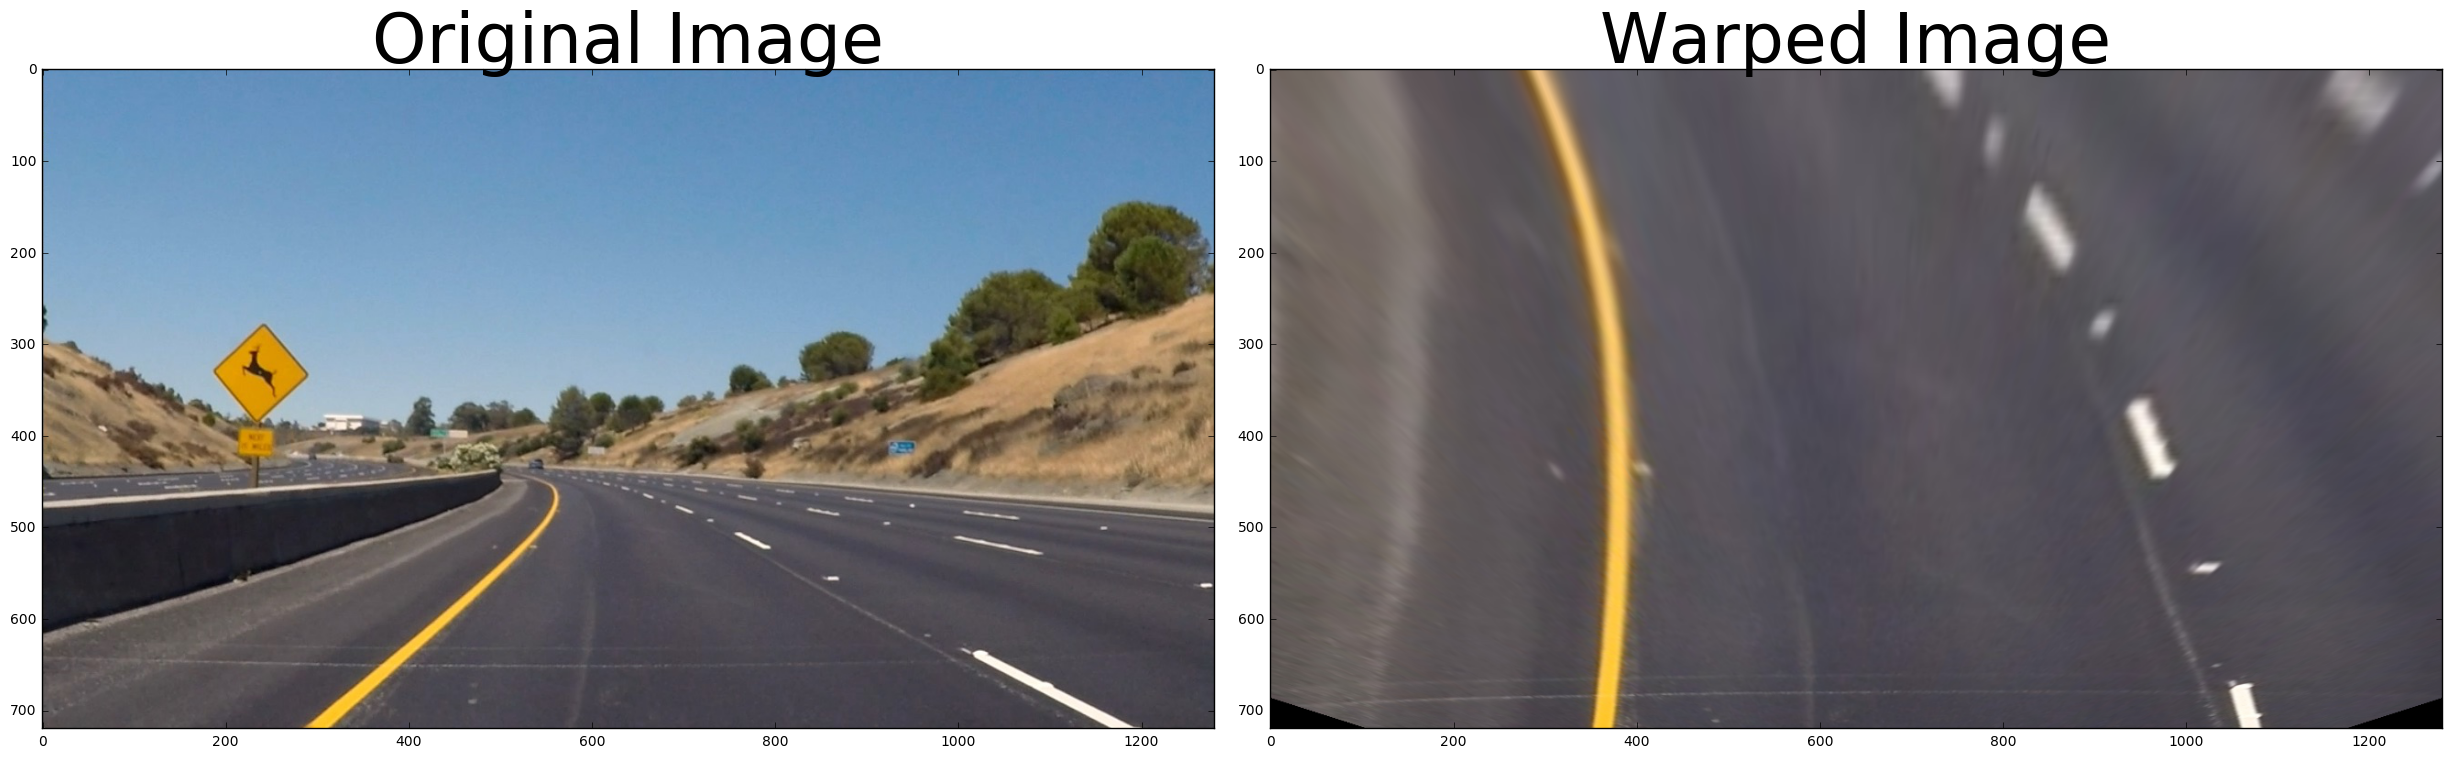

In [139]:
def change_prespective(image, reverse = False):
    src = np.float32([
            [image.shape[1]*0.43, image.shape[0]*0.65],
            [image.shape[1]*0.57, image.shape[0]*0.65],
            [image.shape[1]*0.175, image.shape[0]*0.95],
            [image.shape[1]*0.825, image.shape[0]*0.95],
        ])

    dst = np.float32([
            [image.shape[1]*0.2,image.shape[0]*0.025],
            [image.shape[1]*0.8,image.shape[0]*0.025],
            [image.shape[1]*0.2,image.shape[0]*0.975],
            [image.shape[1]*0.8,image.shape[0]*0.975],
        ])
    
    if (reverse):
        src, dst = dst, src

    M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]))

    return warped

raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/test2.jpg')

undistorted_img = undistort(raw_test_image)

combined = get_binary_image(undistorted_img)

warped = change_prespective(undistorted_img)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(raw_test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Finding the lanes

Curvature: 8842.5m, Center offset: 0.5m


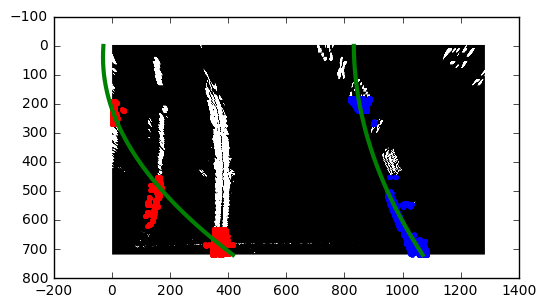

In [138]:
from scipy import signal
import itertools

def get_points_around_x(image, lane_x, low_y):
    image_width = image.shape[1]
    sub_piece_diff = 50
    
    low_x = max(0, lane_x - sub_piece_diff)
    high_x = min(image_width, lane_x + sub_piece_diff)
        
    sub_piece = image[:, low_x:high_x]
    coordinates = np.nonzero(sub_piece)
    coordinates = [coordinates[0] + low_y, coordinates[1] + low_x]
        
    return coordinates

def nearest_value_in_array(array, value):
    if len(array) == 0:
        return None
    
    # http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def get_peaks(image):
    image_width = image.shape[1]
    histogram = np.sum(image, axis=0)
    
    peak_indexes = signal.find_peaks_cwt(histogram, np.arange(image_width * 0.04, image_width * 0.15))
    
    return peak_indexes, histogram
    

def nearest_peak(image, desired_x, tolerance):
    peaks_x, _ = get_peaks(image)
    
    nearest_peak = nearest_value_in_array(peaks_x, desired_x)
    
    if nearest_peak == None or np.abs(nearest_peak - desired_x) > tolerance:
        return None
    
    return nearest_peak

def sorted_peaks(image):
    peak_indexes, histogram = get_peaks(image)
    
    peak_values = [histogram[index] for index in peak_indexes]
    peak_indexes_sorted = [indexes for (values, indexes) in sorted(zip(peak_values, peak_indexes), reverse = True)]
    
    return peak_indexes_sorted

def is_good_fit(fit, weighted_residual = 0, image_width = 1):
    scaled_residual = weighted_residual / image_width
    return fit != None and abs(fit[0]) < 0.001 and scaled_residual < 1.2

def is_good_lanes(lanes, image_width):    
    min_distance = image_width * 0.4
    max_distance = image_width * 0.7
    
    distance = abs(lanes[0] - lanes[1])
    
    return distance >= min_distance and distance <= max_distance

def is_good_lane_fits(left_fit, right_fit, image_width, image_height):
    y_vals = [0, image_height // 2, max(0, image_height - 1)]
    left_fit_x = get_x_for_line(left_fit, y_vals)
    right_fit_x = get_x_for_line(right_fit, y_vals)
    
    result = True
    for i in range(0, len(y_vals)):
        lanes = [left_fit_x[i], right_fit_x[i]]
        if not is_good_lanes(lanes, image_width):
            result = False
            break
    
    return result

def get_lanes_candidates(peaks, image_width):
    lane_ind = list(itertools.combinations(range(0, len(peaks)), 2))
    sum_squares = lambda arr: sum([x**2 for x in arr])
    sort_lane_ind = sorted(lane_ind, key=sum_squares)
    lanes_candidates = [(peaks[peak_indexes[0]], peaks[peak_indexes[1]])  for peak_indexes in sort_lane_ind]
    
    left_lane_solo_ind = set()
    right_lane_solo_ind = set()
    
    lanes_good = []
    
    for index, lanes in enumerate(lanes_candidates):
        if is_good_lanes(lanes, image_width):
            sorted_lanes = lanes
            sorted_lanes_ind = sort_lane_ind[index]
            if lanes[0] > lanes[1]:
                sorted_lanes = [sorted_lanes[1], sorted_lanes[0]]
                sorted_lanes_ind = [sorted_lanes_ind[1], sorted_lanes_ind[0]]
            
            lanes_good.append(sorted_lanes)
            
            left_lane_solo_ind.add(sorted_lanes_ind[0])
            right_lane_solo_ind.add(sorted_lanes_ind[1])
    
    # Cases when one of the lanes cannot be detected
    max_solo_peaks_count = 1
    for i in range(min(max_solo_peaks_count, len(peaks))):
        if i in left_lane_solo_ind:
            lanes_good.append([peaks[i], None])
        if i in right_lane_solo_ind:
            lanes_good.append([None, peaks[i]])
    
    # Cases when neither of the lanes can be detected
    lanes_good.append([None, None])
    
    return lanes_good

def get_piece_points_recursive(image, start_index, pieces_desired, left_lane_coordinates = [[],[]], \
                               right_lane_coordinates = [[],[]]):
    image_height = image.shape[0]
    image_width = image.shape[1]
    piece_height = image_height // pieces_desired
    
    if start_index == -1:
        left_fit, left_residual = fit_line(left_lane_coordinates[1], left_lane_coordinates[0])
        right_fit, right_residual = fit_line(right_lane_coordinates[1], right_lane_coordinates[0])
                
        if is_good_fit(left_fit, left_residual // len(left_lane_coordinates[0]), image_width) \
        and is_good_fit(right_fit, right_residual // len(right_lane_coordinates[0]), image_width) \
        and is_good_lane_fits(left_fit, right_fit, image_width, image_height):
            return left_lane_coordinates, right_lane_coordinates
        else:
            return None, None
    
    piece_index = start_index

    low_y = piece_height * piece_index
    high_y = piece_height * (piece_index + 1)

    piece = image[low_y:high_y, :]
    
    peaks = sorted_peaks(piece)
    
    lanes_candidates = get_lanes_candidates(peaks, image_width)
            
    for lanes in lanes_candidates:        
        candidate_left_lane_coordinates, candidate_right_lane_coordinates = [[],[]], [[],[]]
        
        candidate_left_lane_coordinates[0].extend(left_lane_coordinates[0])
        candidate_left_lane_coordinates[1].extend(left_lane_coordinates[1])
        candidate_right_lane_coordinates[0].extend(right_lane_coordinates[0])
        candidate_right_lane_coordinates[1].extend(right_lane_coordinates[1])

        if lanes[0] != None:            
            coordinates = get_points_around_x(piece, lanes[0], low_y)
            candidate_left_lane_coordinates[0].extend(coordinates[0])
            candidate_left_lane_coordinates[1].extend(coordinates[1])

        if lanes[1] != None:
            coordinates = get_points_around_x(piece, lanes[1], low_y)
            candidate_right_lane_coordinates[0].extend(coordinates[0])
            candidate_right_lane_coordinates[1].extend(coordinates[1])
                    
        new_left_lane_coordinates, new_right_lane_coordinates = get_piece_points_recursive(image, \
                                                                                 start_index - 1, \
                                                                                 pieces_desired, \
                                                                                 candidate_left_lane_coordinates, \
                                                                                 candidate_right_lane_coordinates)
        
        if new_left_lane_coordinates != None and new_right_lane_coordinates != None:
            return new_left_lane_coordinates, new_right_lane_coordinates
    
    return None, None

def get_lane_points(image, left_lane_coordinates = None, right_lane_coordinates = None):
    pieces_desired = 8

    left_lane_coordinates, right_lane_coordinates = get_piece_points_recursive(image, pieces_desired - 1, pieces_desired)

    left_lane_coordinates = np.array(left_lane_coordinates)
    right_lane_coordinates = np.array(right_lane_coordinates)
        
    return left_lane_coordinates, right_lane_coordinates

def fit_line(line_x, line_y, order_polynomial = 2):
    fit, residual, _, _, _ = np.polyfit(line_y, line_x, order_polynomial, full = True)
    return fit, residual
    
def get_x_for_line(line_fit, line_y):
    poly = np.poly1d(line_fit)
    return poly(line_y)

def get_curvature(line_fit, y_eval):
    return ((1 + (2 * line_fit[0] * y_eval + line_fit[1]) ** 2) ** 1.5) \
                             / np.absolute(2 * line_fit[0])

def get_curvature_and_distance_from_center(left_lane_coordinates, right_lane_coordinates, image_width, image_height):
    # Define conversions in x and y from pixels space to meters
    lane_width_pix = image_width * 0.55
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/lane_width_pix # meteres per pixel in x dimension

    left_fit_cr, _ = fit_line(left_lane_coordinates[1] * xm_per_pix, left_lane_coordinates[0] * ym_per_pix)
    right_fit_cr, _ = fit_line(right_lane_coordinates[1] * xm_per_pix, right_lane_coordinates[0] * ym_per_pix)

    left_curverad = get_curvature(left_fit_cr, image_height)
    right_curverad = get_curvature(right_fit_cr, image_height)
    curverad = np.mean([left_curverad, right_curverad])

    left_fitx_bottom_m = get_x_for_line(left_fit_cr, image_height * ym_per_pix)
    right_fitx_bottom_m = get_x_for_line(right_fit_cr, image_height * ym_per_pix)

    center_ideal_m = raw_test_image.shape[1] * xm_per_pix / 2
    center_actual_m = np.mean([left_fitx_bottom_m, right_fitx_bottom_m])

    distance_from_center = abs(center_ideal_m - center_actual_m)
    
    return curverad, distance_from_center

raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/test2.jpg')

undistorted_img = undistort(raw_test_image)

combined = get_binary_image(undistorted_img)

warped = change_prespective(combined)

left_lane_coordinates, right_lane_coordinates = get_lane_points(warped)
    
left_fit, _ = fit_line(left_lane_coordinates[1], left_lane_coordinates[0])
right_fit, _ = fit_line(right_lane_coordinates[1], right_lane_coordinates[0])

image_height = raw_test_image.shape[0]
image_width = raw_test_image.shape[1]

y_vals = np.arange(0, image_height)

left_fitx = get_x_for_line(left_fit, y_vals)
right_fitx = get_x_for_line(right_fit, y_vals)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(warped, cmap='gray')
ax.plot(left_lane_coordinates[1], left_lane_coordinates[0], '.', color='red')
ax.plot(right_lane_coordinates[1], right_lane_coordinates[0], '.', color='blue')
ax.plot(left_fitx, y_vals, color='green', linewidth=3)
ax.plot(right_fitx, y_vals, color='green', linewidth=3)

curverad, distance_from_center = \
    get_curvature_and_distance_from_center(left_lane_coordinates, \
                                           right_lane_coordinates, \
                                           image_width, \
                                           image_height)

stats_text = 'Curvature: {0:.1f}m, Center offset: {1:.1f}m'.format(curverad,
                                                                distance_from_center)
print(stats_text)

# Warp lines back to original image

In [105]:
def draw_lane(image, left_line_points = None, right_line_points = None):  
    image_height = raw_test_image.shape[0]
    
    undistorted_image = undistort(image)

    combined = get_binary_image(undistorted_image)

    warped = change_prespective(combined)
        
    left_lane_coordinates, right_lane_coordinates = \
        get_lane_points(warped, left_line_points, right_line_points)
    
    left_fit, _ = fit_line(left_lane_coordinates[1], left_lane_coordinates[0])
    right_fit, _ = fit_line(right_lane_coordinates[1], right_lane_coordinates[0])
    
    y_vals = np.arange(0, image_height)

    left_fitx = get_x_for_line(left_fit, y_vals)
    right_fitx = get_x_for_line(right_fit, y_vals)

    # Create an image to draw the lines on
    color_warp = np.zeros_like(undistorted_image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, y_vals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, y_vals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = change_prespective(color_warp, reverse = True)
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    
    curverad, distance_from_center = \
    get_curvature_and_distance_from_center(left_lane_coordinates, \
                                           right_lane_coordinates, \
                                           image_width, \
                                           image_height)
    
    stats_text = 'Curvature: {0:.1f}m, Center offset: {1:.1f}m'.format(curverad, \
                                                                distance_from_center)
    text_offset = 50
    text_shift = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, stats_text, \
                (text_offset + text_shift, image_height - text_offset + text_shift), \
                font, 1, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(result, stats_text, (text_offset, image_height - text_offset), \
                font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    return result, [y_vals.tolist(), left_fitx.tolist()], \
                    [y_vals.tolist(), right_fitx.tolist()]

raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images_1/test1.jpg')

result, _, _ = draw_lane(raw_test_image)

plt.imshow(result)

IndexError: too many indices for array

# Video

In [8]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def write_clip(input_file, output_file, function):
    clip = VideoFileClip(input_file)
    
    global left_line_points, right_line_points
    left_line_points = None
    right_line_points = None
    white_clip = clip.fl_image(function) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output_file, audio=False)  


def process_frame(image):
    global left_line_points, right_line_points
    result, left_line_points, right_line_points = draw_lane(image, left_line_points, right_line_points)
    return result

video_input = '../CarND-Advanced-Lane-Lines/harder_challenge_video.mp4'
video_output = 'project_video_solution.mp4'

write_clip(video_input, video_output, process_frame)

HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(video_output))

[MoviePy] >>>> Building video project_video_solution.mp4
[MoviePy] Writing video project_video_solution.mp4


100%|█████████▉| 1199/1200 [33:08<00:01,  1.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_solution.mp4 

CPU times: user 51min 29s, sys: 2min 32s, total: 54min 1s
Wall time: 33min 10s
